In [15]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import src.cfg as cfg
import src.data as data
import src.models as models
import src.processing as processing
import src.filters as fltr

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1200
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams["date.autoformatter.year"] = "%Y"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.style.use('seaborn-whitegrid')

In [4]:
def coords_to_point(coords):
    from src.utils import MyNetCDF
    ncdf = MyNetCDF(path='../data/meta/land-exapmle-int.nc')
    return list(ncdf.coords_to_index(coords)[0].data)

def plotting(pred, y_test, model_data, years_test, fltrd=None,title=None):
    
    # plotting settings

    fig, ax = plt.subplots()
    plt.gca().xaxis.grid(True, linestyle='--')
    
    dates = pd.date_range('01/01/{}'.format(years_test[0]), '31/12/{}'.format(years_test[-1])).to_pydatetime()

    ax.plot(dates, pred, label='Predictions', alpha=0.4)
    ax.plot(dates, y_test, label='Measurements',linewidth=3)
    ax.plot(dates, model_data, label = 'NEMO', alpha=0.8)
    if fltrd is not None:
        ax.plot(dates, fltrd, label = 'Filtered')
    
    ax.axhline(y=0, color='grey', linestyle='-')
    fig.legend()
    fig.autofmt_xdate()

    if title is not None: plt.title(title)
#     plt.show()
    
    return plt

In [ ]:
parameters = dict(years_train=list(range(2010, 2015)),
                  years_test=[2015],
                  X_vars=['ice_conc','icethic_cea', 'tair','vosaline','radlw'],
                  y_var='hice',
                  bounds=[0, 400, 0, 400],
                  step=[20, 20],
                  dx=5,
                  dy=5,
                  dt=5,
                  n_neurons=20,
                  epochs=70,
                  batch_size=30,
                  loss='mae'
                  )
# parameters = dict(years_train=list(range(2010, 2013)),
#                   years_test=[2015],
#                   X_vars=['icethic_cea'],
#                   y_var='thick_cr2smos',
#                   bounds=[0, 400, 0, 400],
#                   step=[20, 20],
#                   dx=0,
#                   dy=0,
#                   dt=5,
#                   n_neurons=20,
#                   epochs=70,
#                   batch_size=30,
#                   loss='mae'
#                   )
filters = dict(partial_pca=5)

y_arr_train, X_arr_train = data.load_features(parameters['y_var'],
                                              parameters['X_vars'],
                                              parameters['years_train'])

y_arr_test, X_arr_test = data.load_features(parameters['y_var'],
                                            parameters['X_vars'],
                                            parameters['years_test'])
mask = np.load(cfg.mask_path)

ft = fltr.FeatureTable(dx=parameters['dx'],
                       dy=parameters['dy'],
                       dt=parameters['dt'])

In [ ]:
n_point=1
points = [[78,84],[80,-5],[73.6,162],[85,-180]]
point = coords_to_point(points[n_point])

model_data = data.load_variable_years('icethic_cea', parameters['years_test'], point)
y_true =data.load_variable_years(parameters['y_var'], parameters['years_test'], point)

In [ ]:
y_train = y_arr_train[:, point[0], point[1]]
y_test = y_arr_test[:, point[0], point[1]]
X_train = ft.gen_matrix(data=X_arr_train, x=point[0], y=point[1], filters=filters)
X_test = ft.gen_matrix(data=X_arr_test, x=point[0], y=point[1], filters=filters)

In [ ]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

reg_params = dict(n_neurons=32,
                  epochs=100,
                  batch_size=40,
                  loss='mean_squared_error')

In [ ]:
lstm = models.MyLSTM()
lstm.fit(X_train, y_train, parameters=reg_params)
pred = lstm.predict(X_test)
pred_fltrd = fltr.Filter.running_mean(pred, 10)

In [ ]:
title = f'Point#{n_point+1}.\nModel: LSTM.\n{reg_params["n_neurons"]} neurons, {reg_params["epochs"]} epochs, {reg_params["batch_size"]} batch_size'

p=plotting(pred, y_true, model_data, parameters['years_test'], fltrd=pred_fltrd, title=title)

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_test)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = scaler.transform(X_train)

lstm = models.MyLSTM()
lstm.fit(X_train_scaled, y_train, parameters=reg_params)
pred = lstm.predict(X_test_scaled)
pred_fltrd = fltr.Filter.running_mean(pred, 10)

In [ ]:
title = f'Point#{n_point+1}.\nModel: LSTM.\n{reg_params["n_neurons"]} neurons, {reg_params["epochs"]} epochs, {reg_params["batch_size"]} batch_size'

p=plotting(pred, y_true, model_data, parameters['years_test'], fltrd=pred_fltrd, title=title)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 32)             856064    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

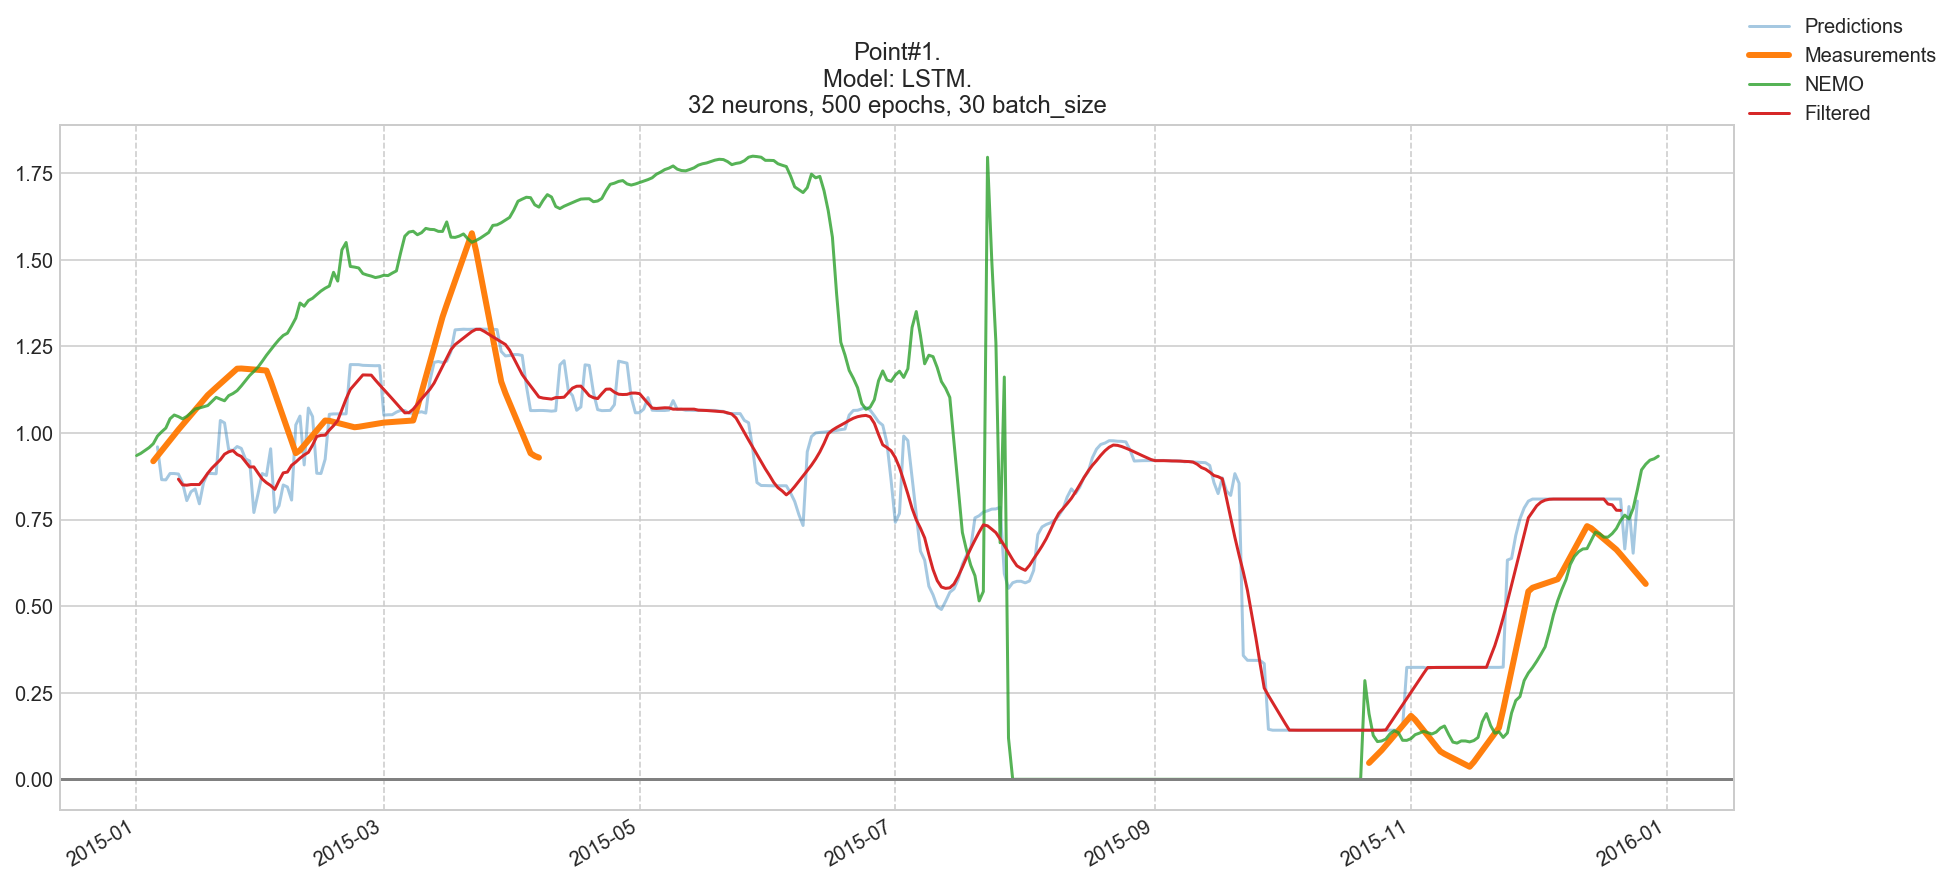

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1, 32)             856064    
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 32)             8320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

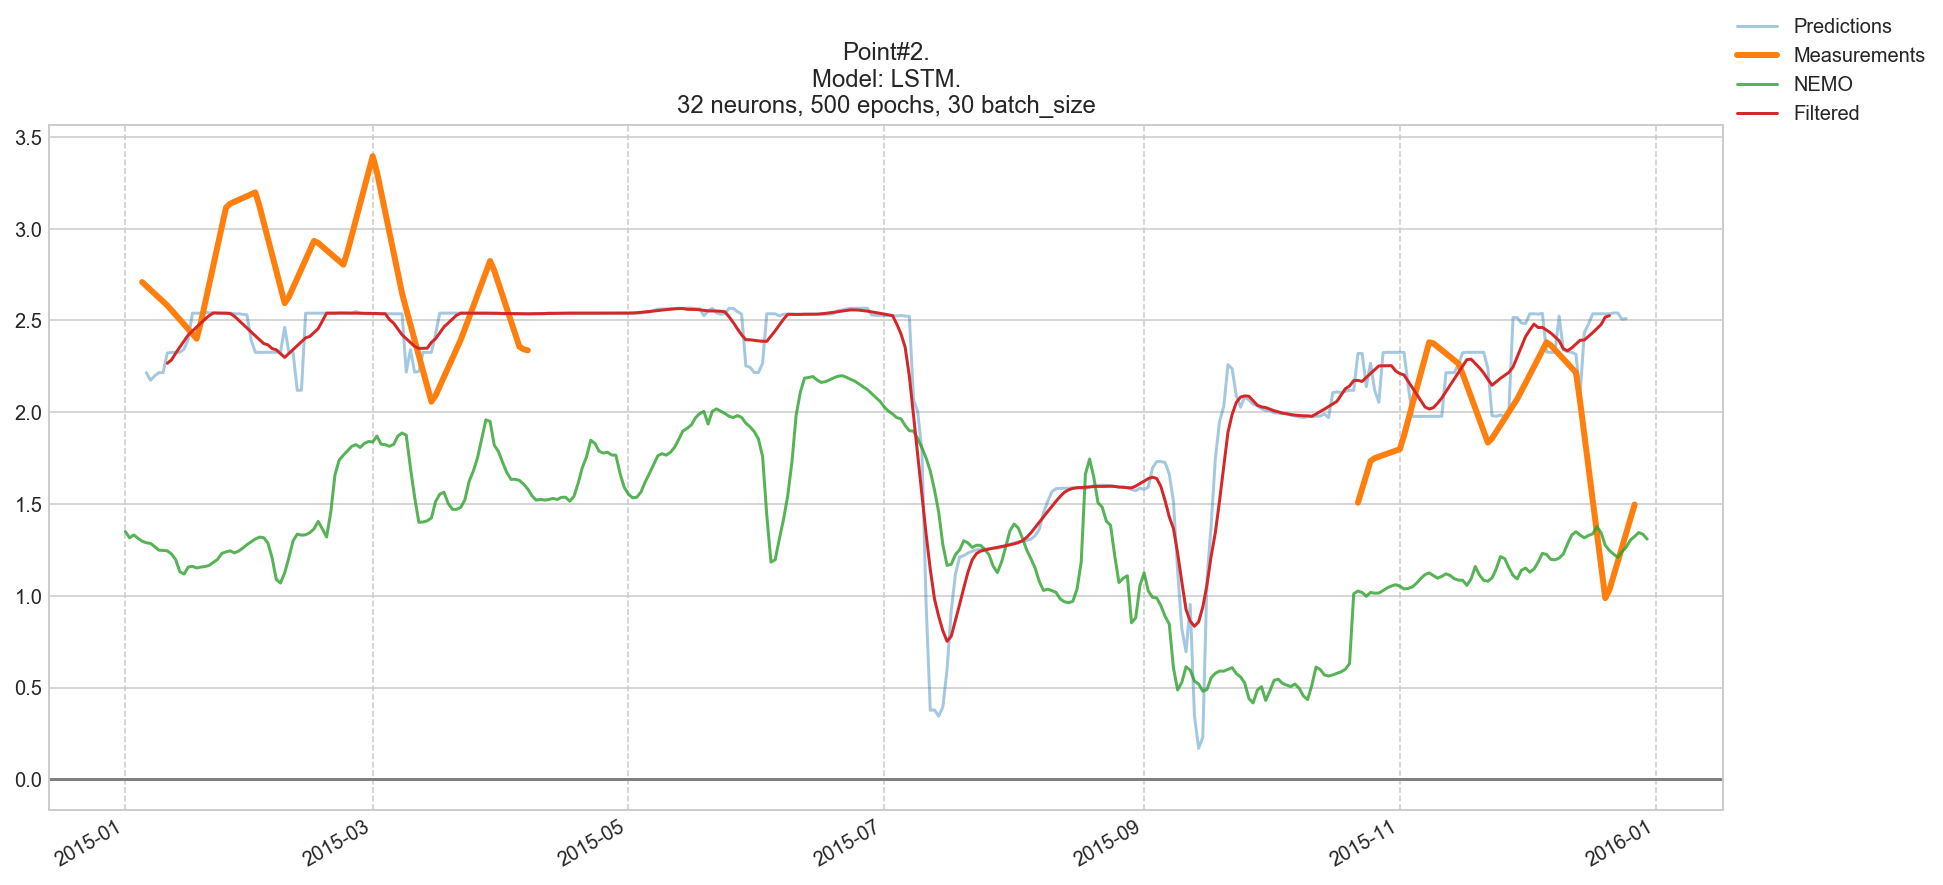

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 1, 32)             856064    
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 1, 32)             8320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

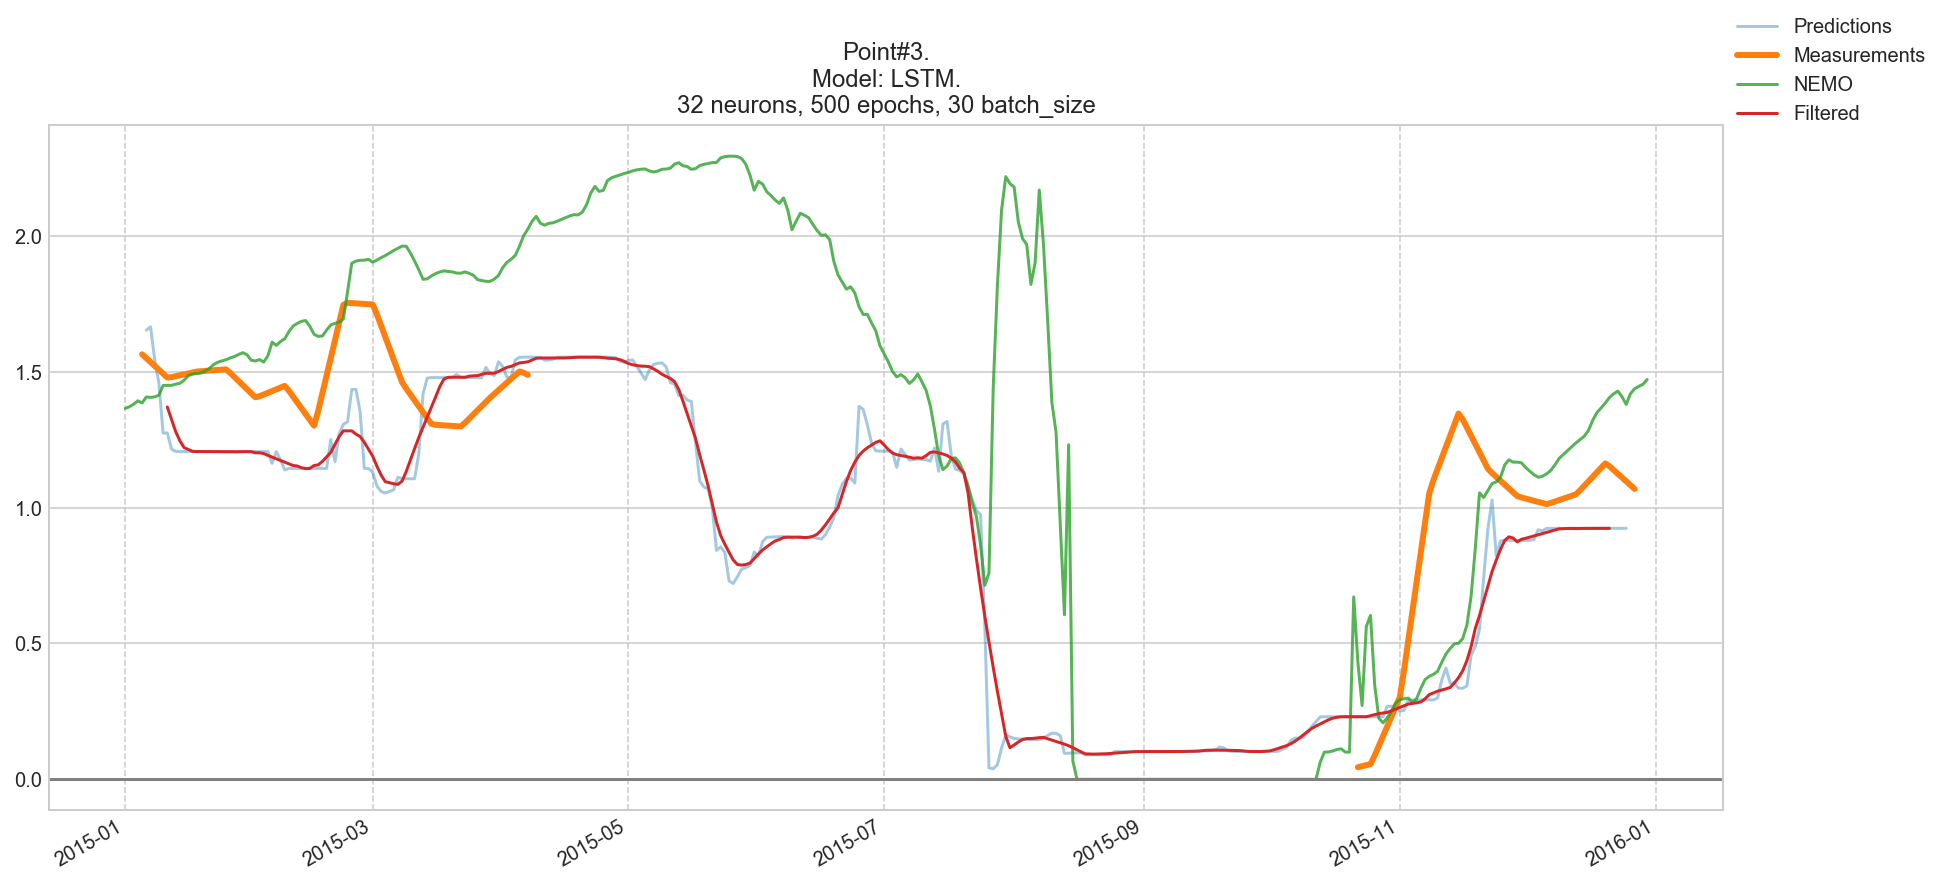

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 1, 32)             856064    
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 1, 32)             8320      
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

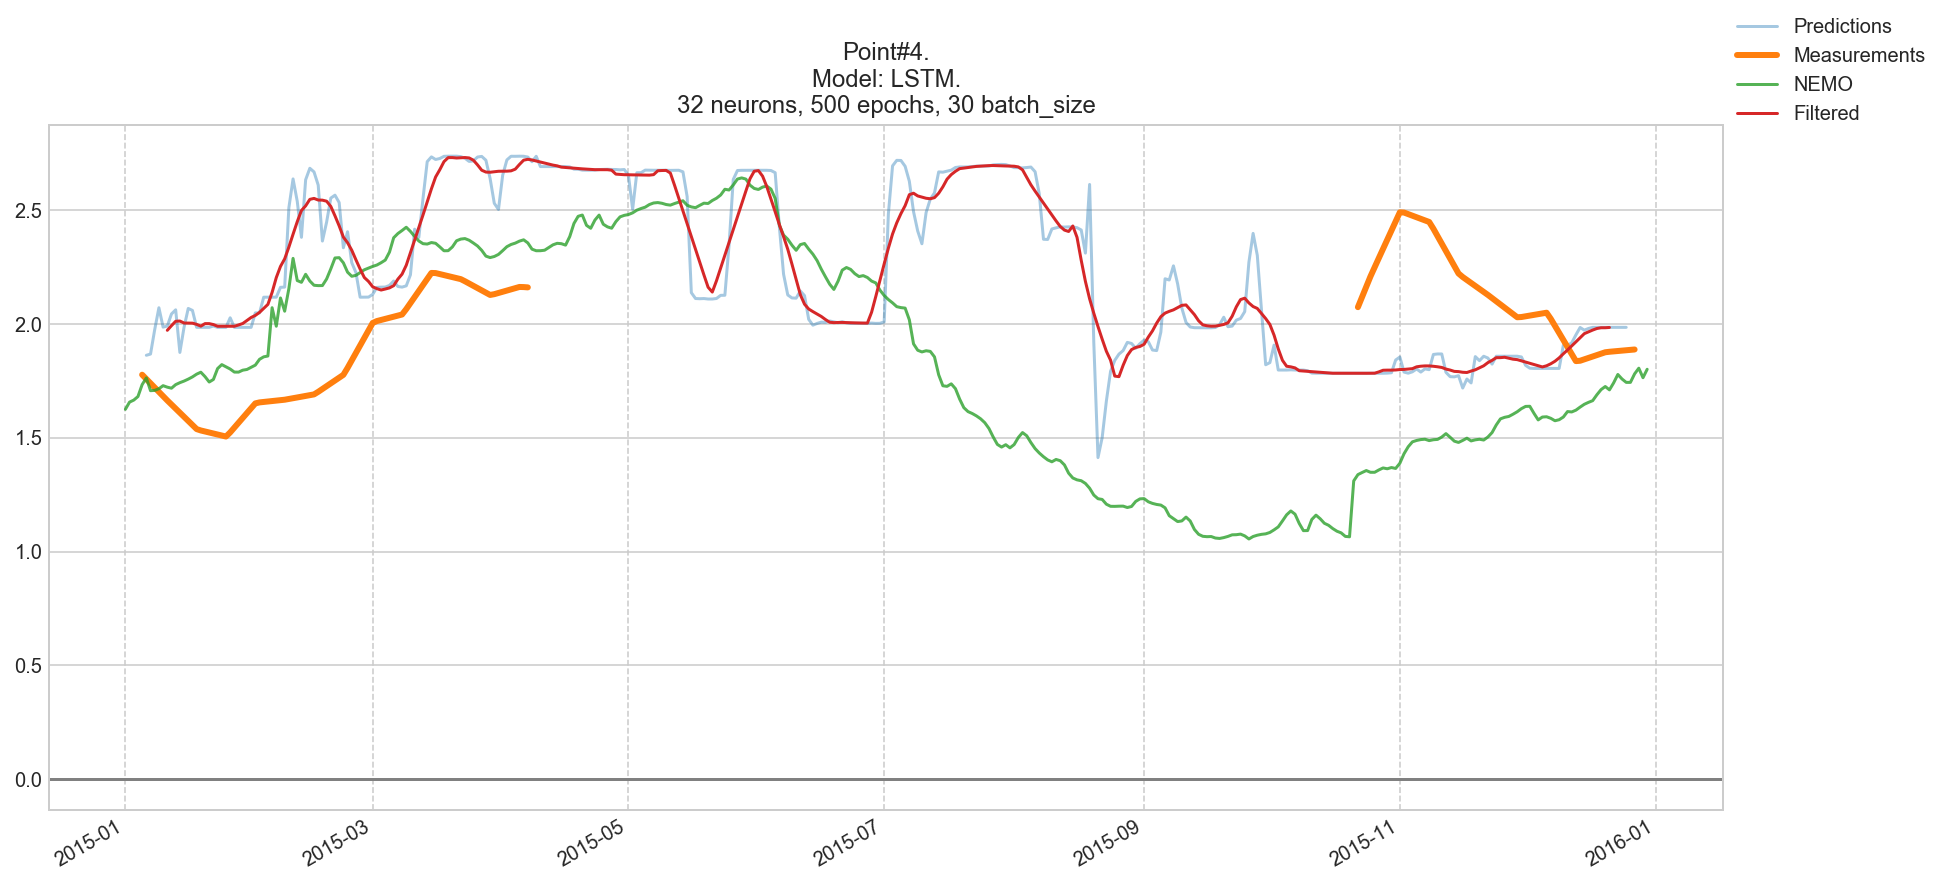

In [13]:
points = [[78,84],[80,-5],[73.6,162],[85,-180]]
reg_params = dict(n_neurons=32,
                  epochs=500,
                  batch_size=30,
                  loss='mean_squared_error')

for n_point, p in enumerate(points):
    point = coords_to_point(points[n_point])

    model_data = data.load_variable_years('icethic_cea', parameters['years_test'], point)
    y_true =data.load_variable_years(parameters['y_var'], parameters['years_test'], point)
    
    y_train = y_arr_train[:, point[0], point[1]]
    y_test = y_arr_test[:, point[0], point[1]]
    X_train = ft.gen_matrix(data=X_arr_train, x=point[0], y=point[1], filters=None)
    X_test = ft.gen_matrix(data=X_arr_test, x=point[0], y=point[1], filters=None)
    
    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_test)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = scaler.transform(X_train)

    lstm = models.MyLSTM()
    lstm.fit(X_train_scaled, y_train, parameters=reg_params)
    pred = lstm.predict(X_test_scaled)
    pred_fltrd = fltr.Filter.running_mean(pred, 10)
    
    title = f'Point#{n_point+1}.\nModel: LSTM.\n{reg_params["n_neurons"]} neurons, {reg_params["epochs"]} epochs, {reg_params["batch_size"]} batch_size'

    p=plotting(pred, y_true, model_data, parameters['years_test'], fltrd=pred_fltrd, title=title)
    p.savefig('/Users/drigo/ITMO/disser/pics/LSTM/LSTM{}_{}.png'.format(3,n_point+1), dpi=300)
    p.show()

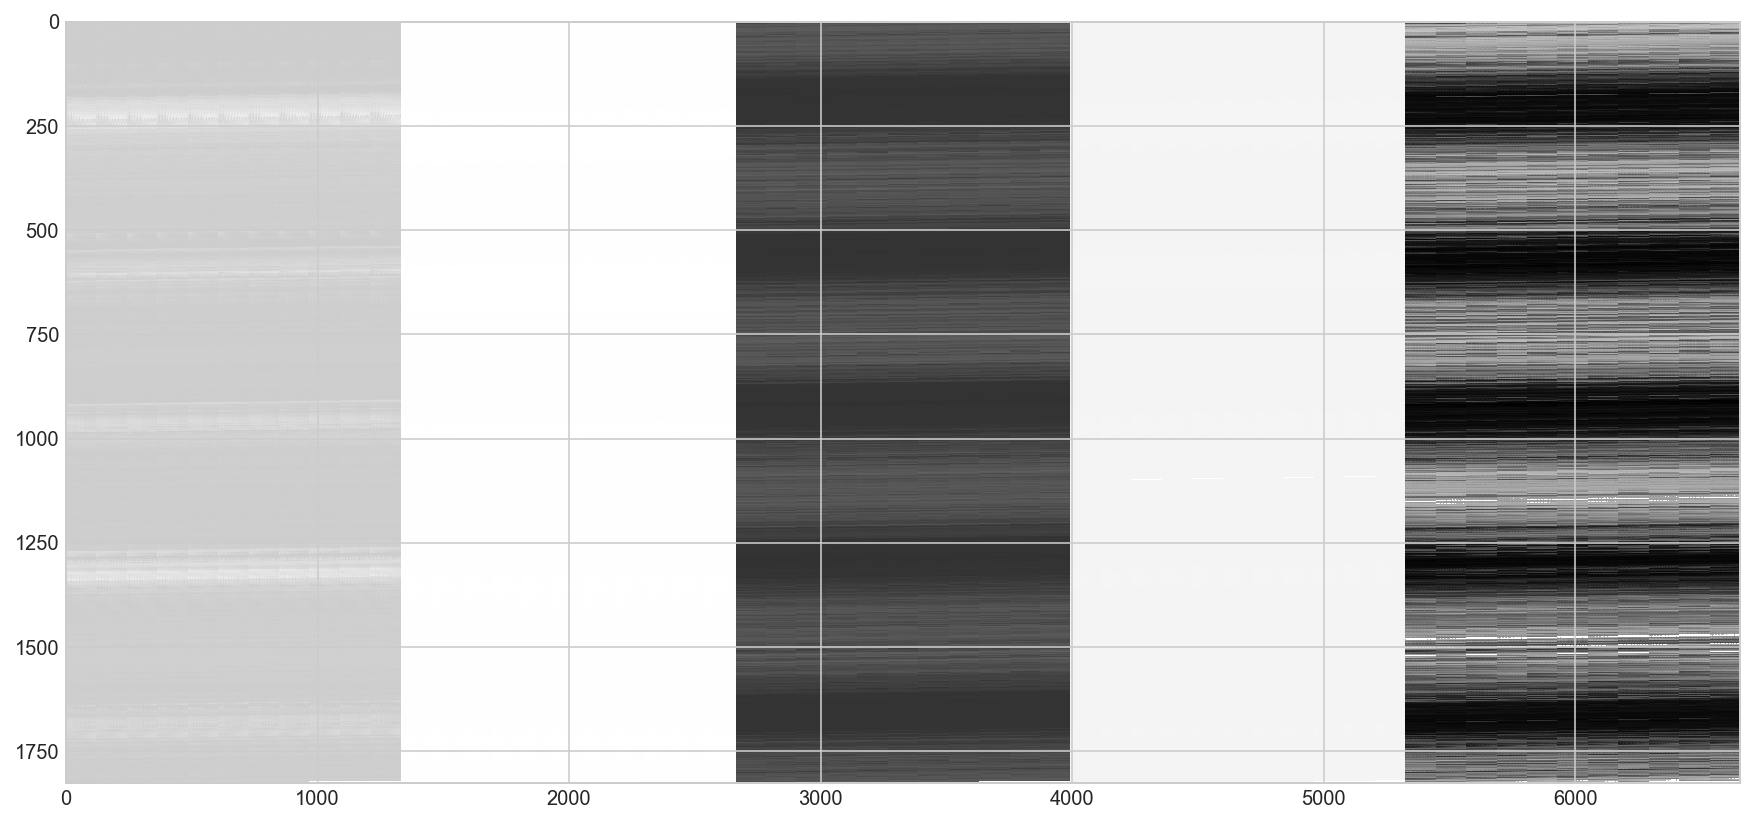

In [14]:
plt.imshow(X_train, aspect='auto')